In [1]:
import geopandas as gpd
import xarray as xr
from rasterio.features import rasterize
from affine import Affine
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Try reading in the model output of estimates of topsoil carbon.
soil_shp = "/gws/ssde/j25b/eds_ai/frame-fm/data/inputs/model_estimates_of_topsoil_carbon/data/CS_topsoil_carbon.shp"
soil_gdf = gpd.read_file(soil_shp)

In [3]:
#Look at the projection information of the shapefile.
soil_gdf.crs

<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.01, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [4]:
#Pick the appropriate columns to process.
all_cols = list(soil_gdf.columns)
CC_cols  = ["CCONC", "LOI", "CDENS"]

filtered = [s for s in all_cols if any(n in s for n in CC_cols)]
print(filtered)

['CCONC_78', 'CCONC_78SE', 'CCONC_98', 'CCONC_98SE', 'CCONC_07', 'CCONC_07SE', 'LOI_78', 'LOI_78SE', 'LOI_98', 'LOI_98SE', 'LOI_07', 'LOI_07SE', 'CDENS_78', 'CDENS_78SE', 'CDENS_98', 'CDENS_98SE', 'CDENS_07', 'CDENS_07SE']


In [5]:
#Get the extent of the dataset geographically
#This will be used to set a raster to remap the data to. 
xmin, ymin, xmax, ymax = soil_gdf.total_bounds
print(xmin, xmax, ymin, ymax)

54000.0 655000.0 11000.0 1219000.0


In [6]:
#Get the number of columns based on the chosen res.
#As we are rounding to the nearest whole number (that sits outside the bounds of the main shapefile) we may lose a little information.
res    = 1000.0
ncol_x = np.int64(np.ceil((xmax - xmin)/res)) + 1
ncol_y = np.int64(np.ceil((ymax - ymin)/res)) + 1
print(ncol_x, ncol_y)

602 1209


In [7]:
#Set the transform required to rasterize the polygon data.
transform = Affine.translation(xmin, ymax) * Affine.scale(1000.0, -1000.0)

In [8]:
#Create a function to rasterise the dataset.
def rasterise_polygons(curr_value, soil_gdf, ncol_x, ncol_y, transform):

    #Create shapes object for current polygon.
    shapes = [(polygon, value) for polygon, value in zip(soil_gdf.geometry, soil_gdf[curr_value])]

    #Rasterise the shapefile.
    return(rasterize(shapes,out_shape=(ncol_y, ncol_x),transform=transform,fill=0,dtype='float32'))

    

In [9]:
#Create the coordinates of the output dataset.
x_coord = np.arange(xmin, xmin + (1000.0*ncol_x), step=1000.0)
y_coord = np.flip(np.arange(ymin, ymin + (1000.0*ncol_y), step=1000.0)) #Need to flip Y_coord due to raster starting in top left.

In [10]:
#Create a blank dataset to store all the output data in - this will be appended to later.
ds_out = ds = xr.Dataset(coords={'x': x_coord, 'y': y_coord})
#Add some attributes - these will be arbitrary for now to demonstrate how it looks but will need adding to later.
ds_out.attrs['Title']  = 'Top Soil Carbon estimates 1km'
ds_out.attrs['crs']    = str(soil_gdf.crs)

In [11]:
#Now add the various rasterised quantities of importance to the dataset.
#At this stage there will be no units and minimal metadata as this is just initial testing of shapefile to xarray dataset.
for f in filtered:

    #Print progress.
    print('Currently processing column: '+f)
    
    #Rasterise the current column.
    curr_val_grd = rasterise_polygons(f, soil_gdf, ncol_x, ncol_y, transform)

    #Convert to xarray object and merge into main dataset.
    da_curr_val = xr.DataArray(curr_val_grd, coords=dict(y=y_coord,x=x_coord), name=f)
    ds_out      = xr.merge([ds_out, da_curr_val])

Currently processing column: CCONC_78
Currently processing column: CCONC_78SE
Currently processing column: CCONC_98
Currently processing column: CCONC_98SE
Currently processing column: CCONC_07
Currently processing column: CCONC_07SE
Currently processing column: LOI_78
Currently processing column: LOI_78SE
Currently processing column: LOI_98
Currently processing column: LOI_98SE
Currently processing column: LOI_07
Currently processing column: LOI_07SE
Currently processing column: CDENS_78
Currently processing column: CDENS_78SE
Currently processing column: CDENS_98
Currently processing column: CDENS_98SE
Currently processing column: CDENS_07
Currently processing column: CDENS_07SE


In [12]:
ds_out

<xarray.Dataset> Size: 52MB
Dimensions:     (x: 602, y: 1209)
Coordinates:
  * x           (x) float64 5kB 5.4e+04 5.5e+04 5.6e+04 ... 6.54e+05 6.55e+05
  * y           (y) float64 10kB 1.219e+06 1.218e+06 ... 1.2e+04 1.1e+04
Data variables: (12/18)
    CCONC_78    (y, x) float32 3MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    CCONC_78SE  (y, x) float32 3MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    CCONC_98    (y, x) float32 3MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    CCONC_98SE  (y, x) float32 3MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    CCONC_07    (y, x) float32 3MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    CCONC_07SE  (y, x) float32 3MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ...          ...
    CDENS_78    (y, x) float32 3MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    CDENS_78SE  (y, x) float32 3MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    CDENS_98    (y, x) float32 3MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    CDENS_98SE  (y, x) float32 3MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    CDENS_07    (y, x) float32 3MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    CDENS_07SE  (y, x) float32 3MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    Title:    Top Soil Carbon estimates 1km
    crs:      EPSG:27700

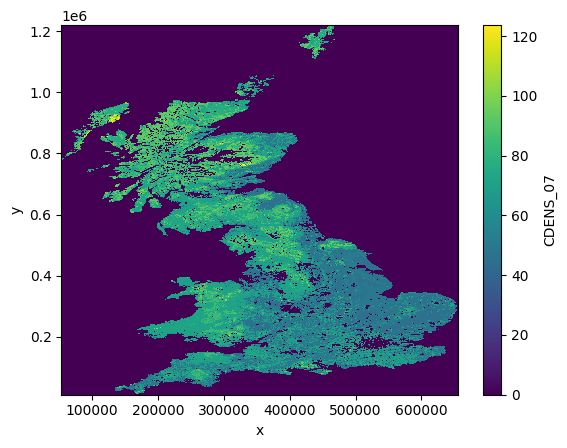

In [13]:
#Plot a couple of quantities to check if looks sensible.
ds_out['CDENS_07'].plot() 

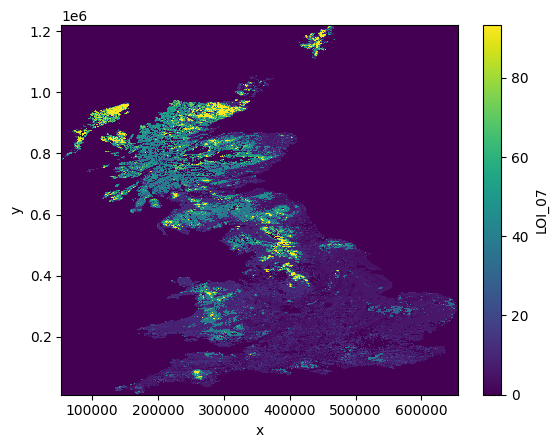

In [14]:
#Plot a couple of quantities to check if looks sensible.
ds_out['LOI_07'].plot()

In [15]:
#write the output to a netcdf.
#Note this is just a test netcdf to check workflow of dataloader - a better version needs to be created to add correct metadata.
fout = '/gws/ssde/j25b/eds_ai/frame-fm/users/mjholl/CS_topsoil_carbon.nc'
ds_out.to_netcdf(fout)